In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy

from tqdm import tqdm
from torch.utils.data import Dataset

import os
import tifffile
import trackpy as tp
import warnings
import logging

In [64]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    torch.cuda.empty_cache()
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

NVIDIA GeForce RTX 3080
Memory Usage:
Allocated: 0.4 GB
Cached:    1.4 GB


# Load Data

In [3]:
def get_PSF_frame(movie_frame, x, y, frame_size, keep_edges=False):
    half_frame = int(frame_size/2)
    int_x = round(x); int_y = round(y)
    lower_x = int_x - half_frame
    lower_y = int_y - half_frame
    upper_x = int_x + half_frame + 1
    upper_y = int_y + half_frame + 1
    upper_limit_x = movie_frame.shape[1]
    upper_limit_y = movie_frame.shape[0]
    if keep_edges:
        if lower_x < 0:
            lower_x = 0
        if lower_y < 0:
            lower_y = 0
        if upper_x > upper_limit_x:
            upper_x = upper_limit_x
        if upper_y > upper_limit_y:
            upper_y = upper_limit_y
    else:
        if lower_x < 0 or lower_y < 0 or upper_x > upper_limit_x or upper_y > upper_limit_y:
            return False
    return np.array(movie_frame)[lower_y:upper_y, lower_x:upper_x]

def get_PSF_frames(movie, minmass=2000, separation=3, diameter=7, frame_size=13, percentile=0.9, to_plot=False, movie_frames=True, dpi=100):
    if type(movie_frames) == bool:
        movie_frames = range(len(movie))
    
    # Initialize an empty list to store the PSF frames
    PSF_frames = []

    # Loop through each frame in the movie
    for i in movie_frames:
        # Perform localization on the frame
        full_frame = tp.locate(movie[i], diameter=diameter, 
                        minmass=minmass, max_iterations=10,
                        separation=separation, percentile=percentile)  # Adjust the minmass parameter as needed

        # Plot the frame with the identified features
        if to_plot:
            fig, ax = plt.subplots(1, dpi=dpi)
            ax.imshow(movie[i], cmap='gray')

        # Draw a box around each identified feature
        for index, row in full_frame.iterrows():
            if to_plot:
                rect = patches.Rectangle((row['x']-int(frame_size/2), row['y']-int(frame_size/2)), frame_size, frame_size, linewidth=1, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
            PSF_frame = get_PSF_frame(movie[i], row['x'], row['y'], frame_size)
            if type(PSF_frame) == bool:
                continue
            PSF_frames.append(PSF_frame)
        if to_plot:
            plt.title(f'Full Frame {i}')
            plt.show()

    # Convert the list of frames to a numpy array
    PSF_frames = np.array(PSF_frames)
    return PSF_frames

def get_PSF_frames_movie_list(movies, minmass=2000, separation=3, diameter=7, frame_size=13, percentile=0.9):
    first = True
    for movie in movies:
        if first:
            PSF_list = get_PSF_frames(movie, minmass, separation, diameter, frame_size, percentile)
            first = False
        else:
            PSF_list = np.concatenate((PSF_list, get_PSF_frames(movie, minmass, separation, diameter, frame_size, percentile)))
    return PSF_list

def show_PSFs(PSF_frames, random=True):
    print(PSF_frames.shape)
    num_PSFs = 15
    if not random:
        random_seed = 1 # random seed for reproducibility
        np.random.seed(random_seed)
    PSF_indices = np.random.choice(PSF_frames.shape[0], size=num_PSFs, replace=False)
    image_list = PSF_frames[PSF_indices]

    # Creating a 2x5 subplot grid
    fig, axes = plt.subplots(3, 5, figsize=(10, 4), dpi=150)

    # Flattening the 2D array of axes to a 1D array
    axes = axes.flatten()

    # Iterating over each image and corresponding axis
    for i in range(len(axes)):
        # Displaying the image on the corresponding axis
        axes[i].imshow(image_list[i], cmap='gray')
        axes[i].axis('off')

    plt.suptitle("Examples of PSF Frames", fontsize=24)
    plt.tight_layout()
    plt.show()

def load_tif_movies(folder_path):
    movies = []
    logger = logging.getLogger('tifffile')
    prev_level = logger.getEffectiveLevel()  # get the current logging level
    logger.setLevel(logging.ERROR)  # set level to ERROR, only ERROR level and above will be shown
    try:
        for filename in os.listdir(folder_path):
            # Check if the current file is a .tif file
            if filename.endswith('.tif'):
                # Construct the full filepath by joining the directory path and the filename
                filepath = os.path.join(folder_path, filename)
                movies.append(tifffile.imread(filepath))
    finally:
        logger.setLevel(prev_level)  # reset the logging level to its previous state
    return movies


## Tons of Data for Training

In [4]:
A647_movies = load_tif_movies('Raw Data\A647')
CF660_movies = load_tif_movies('Raw Data\CF660c')
print(len(A647_movies), len(CF660_movies))

8 12


In [5]:
minmass = 3500
separation = 15
diameter = 9
frame_size = 19
percentile =99.5
# with warnings.catch_warnings():
#     warnings.filterwarnings("ignore", category=UserWarning)
#     A647_PSFs = get_PSF_frames_movie_list(A647_movies, minmass, separation, diameter, frame_size, percentile)

In [6]:
# with open('PSF Frames\A647_combined_PSFs.npy', 'wb') as f:
#     np.save(f, A647_PSFs)
with open('PSF Frames\A647_combined_PSFs.npy', 'rb') as f:
    A647_PSFs = np.load(f)

(199604, 19, 19)


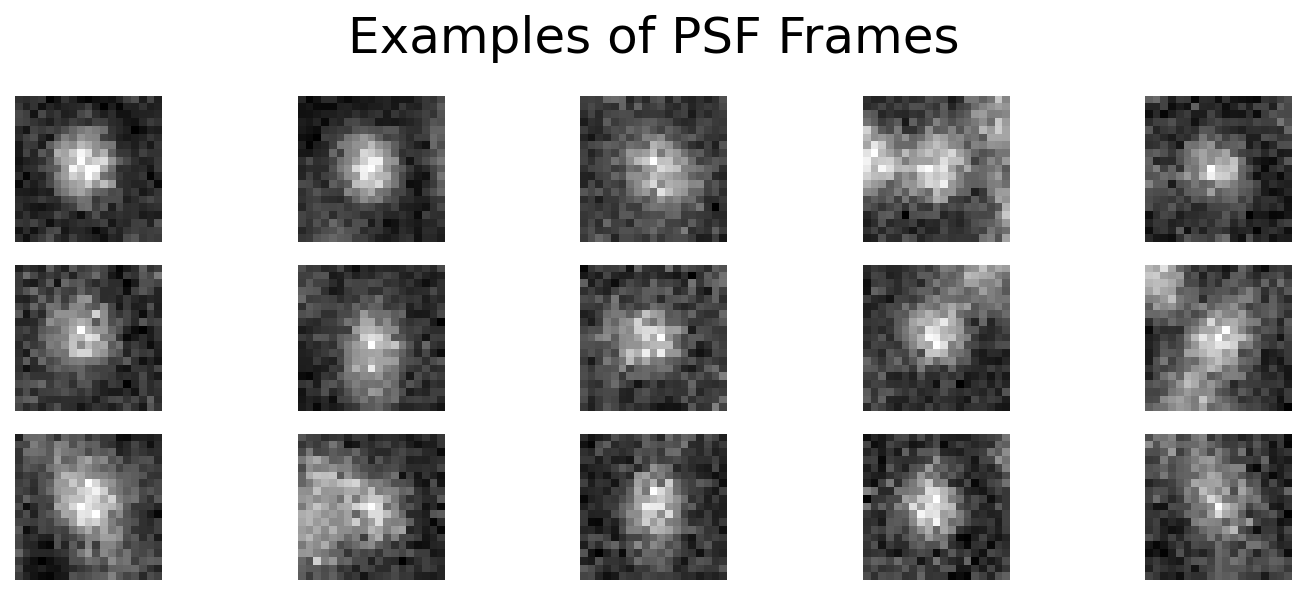

In [7]:
show_PSFs(A647_PSFs)

In [8]:
minmass = 3500
separation = 15
diameter = 9
frame_size = 19
percentile =99.5
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning)
    CF660_PSFs = get_PSF_frames_movie_list(CF660_movies, minmass, separation, diameter, frame_size, percentile)

In [9]:
# with open('PSF Frames\CF660c_combined_PSFs.npy', 'wb') as f:
#     np.save(f, CF660_PSFs)
with open('PSF Frames\CF660c_combined_PSFs.npy', 'rb') as f:
    CF660_PSFs = np.load(f)

(99769, 19, 19)


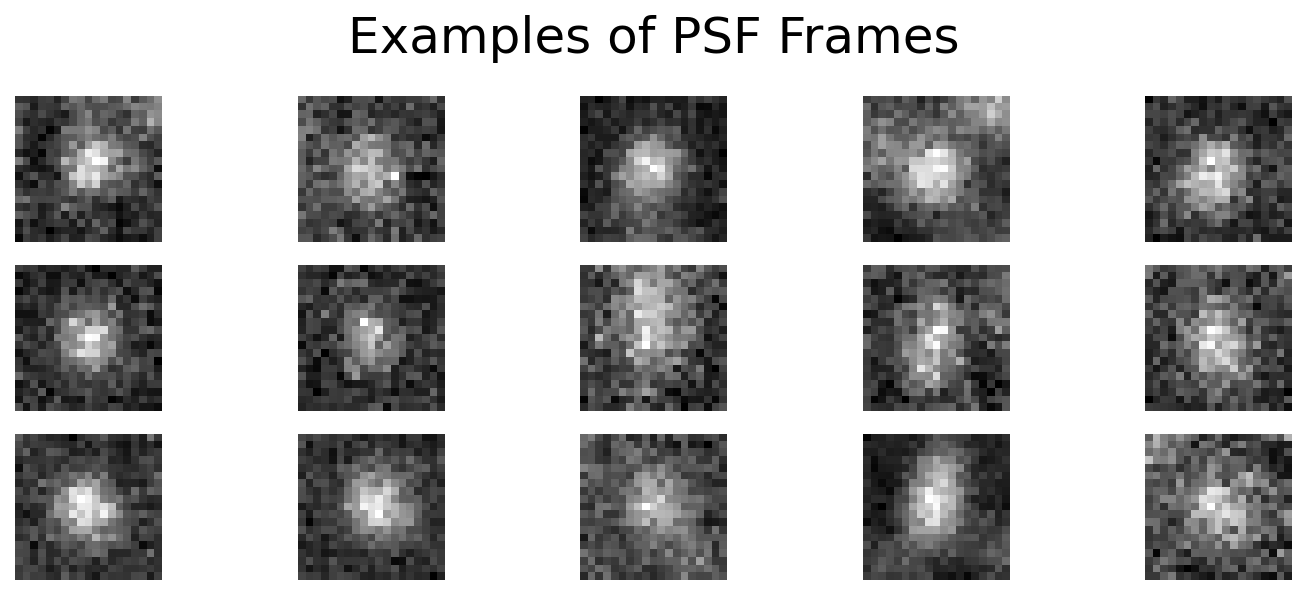

In [10]:
show_PSFs(CF660_PSFs)

In [11]:
# Assign data to classes
classes = {'A': "A647", 'B': "CF660c"}
A_raw = A647_PSFs
B_raw = CF660_PSFs

# Reduce the size of the larger dataset
if len(A_raw) < len(B_raw):
    B_raw = B_raw[np.random.choice(range(len(B_raw)), len(A_raw))]
else:
    A_raw = A_raw[np.random.choice(range(len(A_raw)), len(B_raw))]

# Combine, create labels, and reshuffle all
all_data = np.concatenate((A_raw, B_raw)).astype(np.int32)
labels = np.concatenate((np.zeros(len(A_raw)), np.ones(len(B_raw))))

random_seed = 1 # random seed for reproducibility
np.random.seed(random_seed)
all_indices = np.random.choice(np.arange(len(all_data)), size=len(all_data), replace=False)

In [12]:
class PSFDataset(Dataset):
    def __init__(self, train, split=0.85):
        if train:
            self.images = torch.from_numpy(all_data[all_indices[:int(split*len(all_indices))]]).unsqueeze(1).cuda()
            self.labels = torch.from_numpy(labels[all_indices[:int(split*len(all_indices))]]).long().cuda()
        else:
            self.images = torch.from_numpy(all_data[all_indices[int(split*len(all_indices)):]]).unsqueeze(1).cuda()
            self.labels = torch.from_numpy(labels[all_indices[int(split*len(all_indices)):]]).long().cuda()
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        return self.images[idx].float(), self.labels[idx]

# make training set
PSF_training = PSFDataset(True)
# make testing set
PSF_testing = PSFDataset(False)

print(len(PSF_training))
print(len(PSF_testing))

169607
29931


## Good Data for Post-Training Testing

In [13]:
# Load the TIFF movie for Good Data
A647_movie = tifffile.imread('Raw Data\Good Data\A647-GoatAntiMouse-No1CG-100EMG-50ms_28mW.tif')
CF660_movie = tifffile.imread('Raw Data\Good Data\CF660c-GaM_No1CG_100EMG_50ms_28mW647_0mW405.tif')
print(f"A647 Frame Count: {len(A647_movie)}")
print(f"CF660 Frame Count: {len(CF660_movie)}")

<tifffile.TiffTag 5033 @530844> coercing invalid ASCII to bytes


<tifffile.TiffTag 5033 @530844> coercing invalid ASCII to bytes


A647 Frame Count: 100
CF660 Frame Count: 500


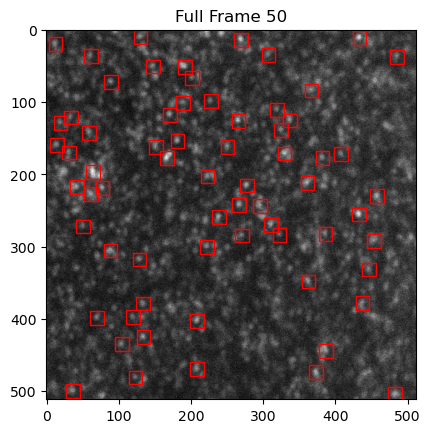

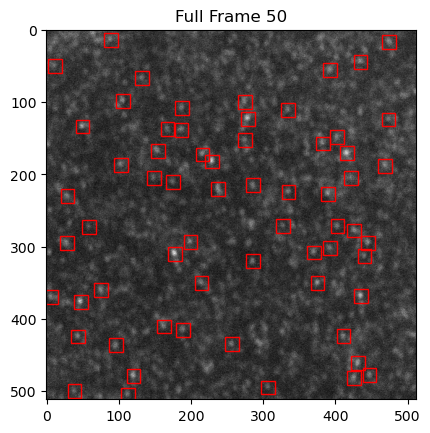

In [19]:
minmass = 3500
separation = 15
diameter = 9
frame_size = 19
percentile =99.5
indices = [50]

A647_PSF_frames = get_PSF_frames(A647_movie, minmass, separation, diameter, frame_size, percentile, to_plot=True, movie_frames=indices)
# A647_PSF_frames = get_PSF_frames(A647_movie, minmass, separation, diameter, frame_size, percentile, to_plot=False, movie_frames=True)
CF660_PSF_frames = get_PSF_frames(CF660_movie, minmass, separation, diameter, frame_size, percentile, to_plot=True, movie_frames=indices)
# CF660_PSF_frames = get_PSF_frames(CF660_movie, minmass, separation, diameter, frame_size, percentile, to_plot=False, movie_frames=True)

In [18]:
# with open('PSF Frames\A647_good_PSFs.npy', 'wb') as f:
#     np.save(f, A647_PSF_frames)
# with open('PSF Frames\CF660c_good_PSFs.npy', 'wb') as f:
#     np.save(f, CF660_PSF_frames)
with open('PSF Frames\A647_good_PSFs.npy', 'rb') as f:
    A647_PSF_frames = np.load(f)
with open('PSF Frames\CF660c_good_PSFs.npy', 'rb') as f:
    CF660_PSF_frames = np.load(f)

(6598, 19, 19)


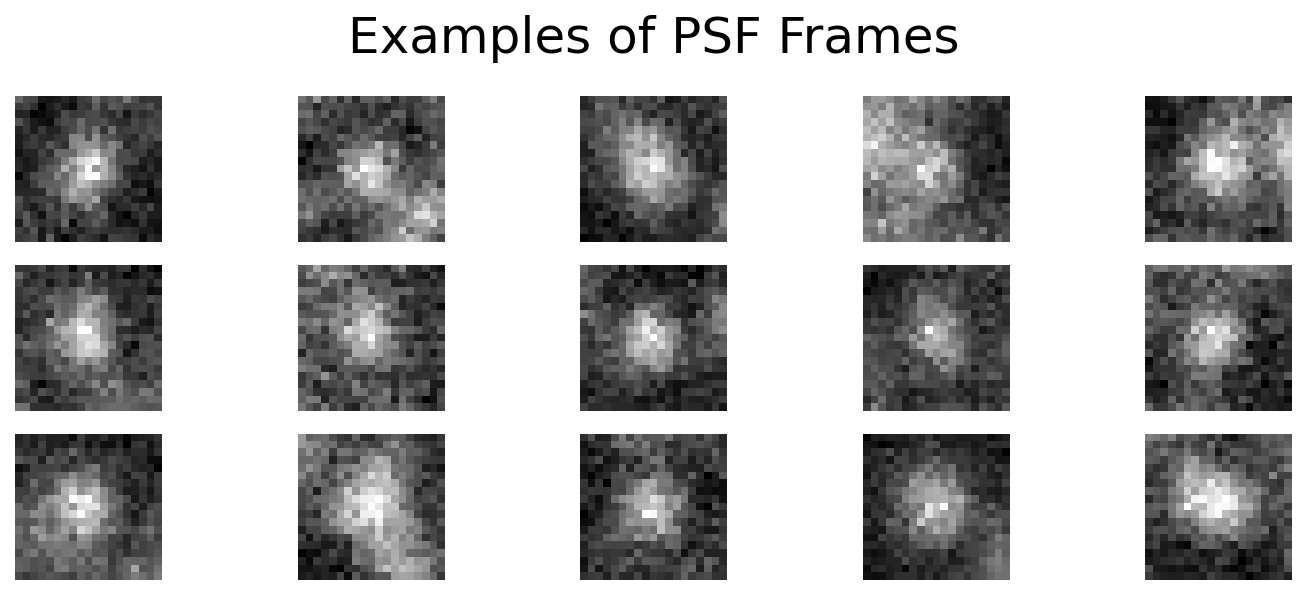

(27518, 19, 19)


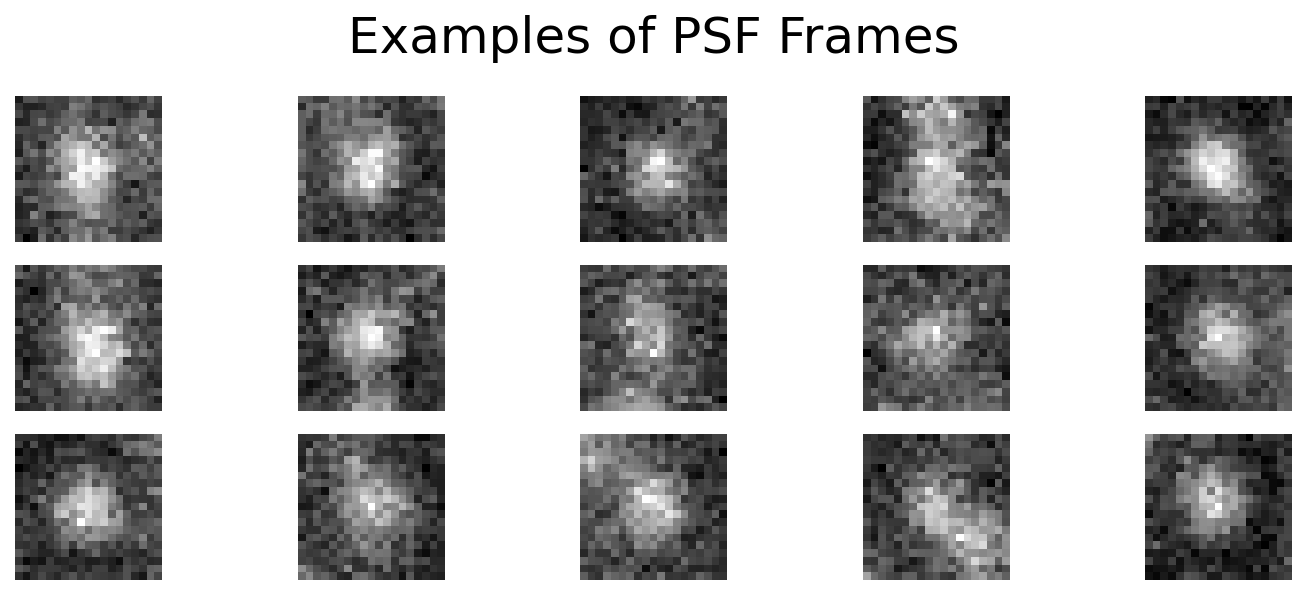

In [15]:
show_PSFs(A647_PSF_frames)
show_PSFs(CF660_PSF_frames)

In [16]:
# Assign data to classes
classes = {'A': "A647", 'B': "CF660c"}
A_raw = A647_PSF_frames
B_raw = CF660_PSF_frames

# Reduce the size of the larger dataset
if len(A_raw) < len(B_raw):
    B_raw = B_raw[np.random.choice(range(len(B_raw)), len(A_raw))]
else:
    A_raw = A_raw[np.random.choice(range(len(A_raw)), len(B_raw))]

# Combine, create labels, and reshuffle all
all_data = np.concatenate((A_raw, B_raw)).astype(np.int32)
labels = np.concatenate((np.zeros(len(A_raw)), np.ones(len(B_raw))))

random_seed = 1 # random seed for reproducibility
np.random.seed(random_seed)
all_indices = np.random.choice(np.arange(len(all_data)), size=len(all_data), replace=False)

In [17]:
# make testing set
PSF_good_testing = PSFDataset(True, split=1)
print(len(PSF_good_testing))

13196


# Model Code

## Function Definitions

In [20]:
# model code for simple convolutional nerual network followed by fully connected layers
class CNN_FC(nn.Module):
    # constructor
    def __init__(self, channel_widths, linear_sizes, kernel, pooling, nonlinearity=nn.ReLU()):
        super(CNN_FC, self).__init__()
        layers = []
        for i in range(len(channel_widths)-2):
            layers.append(nn.Conv2d(channel_widths[i], channel_widths[i+1],
                                    kernel_size=kernel, padding=2, stride=1, bias=True))
            layers.append(nonlinearity)
        layers.append(nn.Conv2d(channel_widths[-2], channel_widths[-1],
                                    kernel_size=kernel, padding=2, stride=1, bias=True))
        self.backbone = nn.Sequential(*layers)
        self.global_pooling = pooling
        self.pool_size = pooling.output_size[0]*pooling.output_size[1]

        # Defining the fully connected layers
        fc_layers = []
        in_features = channel_widths[-1]*self.pool_size
        for size in linear_sizes:
            fc_layers.append(nn.Linear(in_features, size))
            fc_layers.append(nonlinearity)
            in_features = size
        self.fully_connected = nn.Sequential(*fc_layers)

        self.linear = nn.Linear(in_features, 2)  # score each class to obtain logits

    # forward pass
    def forward(self, x):
        B = x.size(0)
        features = self.backbone(x)
        pooled_features = self.global_pooling(features)
        pooled_features = pooled_features.view(B, -1)
        fc_output = self.fully_connected(pooled_features)
        logits = self.linear(fc_output)
        return logits

In [21]:
def train(model, all_data, training_indices, validation_indices, config, verbose=False):
    # unpack configuration parameters
    lr = config['lr'] # learning rate
    n_epochs = config['n_epochs'] # number of passes (epochs) through the training data
    batch_size = config['batch_size']
    
    # set up optimizer and loss function
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()
    
    # set up dataloaders
    train_sampler = torch.utils.data.SubsetRandomSampler(training_indices)
    val_sampler = torch.utils.data.SubsetRandomSampler(validation_indices)
    trainloader = torch.utils.data.DataLoader(all_data, batch_size=batch_size, sampler=train_sampler)
    valloader = torch.utils.data.DataLoader(all_data, batch_size=batch_size, sampler=val_sampler)
    
    # training loop
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    best_val_accuracy = 0
    best_model = None
    for n in range(n_epochs):
        # set model to training mode (unnecessary for this model, but good practice)
        model.train()
        epoch_loss = 0
        epoch_acc = 0
        for images, targets in trainloader:
            optimizer.zero_grad() # zero out gradients
            class_logits = model(images)
            loss = criterion(class_logits, targets)
            loss.backward() # backpropagate to compute gradients
            optimizer.step() # update parameters using stochastic gradient descent
            # update epoch statistics
            epoch_loss += loss.item() # batch loss
            epoch_acc += (class_logits.data.max(1)[1]).eq(targets).sum().item() # number of correct predictions
            
        # validation
        epoch_loss /= len(trainloader)
        epoch_acc /= len(training_indices)
        val_loss, val_acc = validate(model, valloader, criterion)
        val_loss /= len(valloader)
        val_acc /= len(validation_indices)
        
        # log epoch information
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        # save best model, if necessary
        if val_acc > best_val_accuracy:
            best_model = copy.deepcopy(model)
        if verbose and (n+1) % (int(n_epochs/20)) == 0:
            print('Epoch {}/{}: (Train) Loss = {:.4e}, Acc = {:.4f}, (Val) Loss = {:.4e}, Acc = {:.4f}'.format(
                   n+1,
                   n_epochs,
                   epoch_loss,
                   epoch_acc,
                   val_loss,
                   val_acc))
        
        
    return (np.array(train_losses),
            np.array(train_accuracies),
            np.array(val_losses),
            np.array(val_accuracies),
            best_model)
        
def validate(model, dataloader, criterion):
    val_loss = 0
    val_acc = 0
    # set model to eval mode (again, unnecessary here but good practice)
    model.eval()
    # don't compute gradients since we are not updating the model, saves a lot of computation
    with torch.no_grad():
        for images, targets in dataloader:
            class_logits = model(images)
            loss = criterion(class_logits, targets)
            val_loss += loss.item()
            val_acc += (class_logits.data.max(1)[1]).eq(targets).sum().item()
    return val_loss, val_acc

def test(model, dataset):
    # test best model on withheld test data
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=128)
    test_acc = 0
    model.eval()
    with torch.no_grad():
        for images, targets in dataloader:
            class_logits = model(images)
            test_acc += (class_logits.data.max(1)[1]).eq(targets).sum().item()
    return test_acc/len(dataset)

# plot training/validation loss and accuracy over training time
def plot_model_results():
    plt.figure(figsize=(15, 10))
    plt.subplot(221)
    plt.semilogy(train_losses, color='royalblue')
    plt.xlabel('Epoch')
    plt.title('Training loss')
    plt.grid(True)
    plt.subplot(222)
    plt.plot(train_accs, color='darkorange')
    plt.xlabel('Epoch')
    plt.title('Training accuracy')
    plt.grid(True)
    plt.subplot(223)
    plt.plot(val_losses, color='royalblue')
    plt.xlabel('Epoch')
    plt.title('Validation loss')
    plt.grid(True)
    plt.subplot(224)
    plt.plot(val_accs, color='darkorange')
    plt.xlabel('Epoch')
    plt.title('Validation accuracy')
    plt.grid(True)

## Training and Testing

### Model 9

In [38]:
# metrics visualization

# data
# you can try playing around with more or less training data
N_training_examples = 5000 # 100 examples per class
N_validation_examples = 2500 # 100 examples per class
random_seed = 1 # random seed for reproducibility
np.random.seed(random_seed)
all_train_indices = np.random.choice(np.arange(len(PSF_training)),
                               size=2*N_training_examples+N_validation_examples)
# Make two unique training/validation sets for change partway through training if desired
all_train_indices_1 = all_train_indices[:int(len(all_train_indices)/2)]
all_train_indices_2 = all_train_indices[int(len(all_train_indices)/2):]
training_indices_1 = all_train_indices_1[:N_training_examples]
validation_indices_1 = all_train_indices_1[N_training_examples:]
training_indices_2 = all_train_indices_2[:N_training_examples]
validation_indices_2 = all_train_indices_2[N_training_examples:]

# configuration parameters, you can play around with these
pooling = 'max' # 'max' or 'mean'

if pooling == 'max':
    pool_fcn = nn.AdaptiveMaxPool2d((1, 1))
else:
    pool_fcn = nn.AdaptiveAvgPool2d((1, 1))
# model
# your model will have length(channel_widths)-1 layers
channel_widths = [1, 64, 128, 128, 256, 256, 512, 512] # must start with a 1 and be at least length--2
linear_sizes = [256]
kernel = 3
model_9 = CNN_FC(channel_widths, linear_sizes, kernel, pool_fcn)

#### Old Runs

In [39]:
config = {'lr': 3e-4,
          'n_epochs': 100,
          'batch_size': 128}
# train
verbose = True # print metrics during training, False for no printing
train_losses, train_accs, val_losses, val_accs, best_model = train(model_9.cuda(),
                                                                   PSF_training,
                                                                   training_indices_1,
                                                                   validation_indices_1,
                                                                   config,
                                                                   verbose=verbose)

Epoch 5/100: (Train) Loss = 6.2862e-01, Acc = 0.6246, (Val) Loss = 6.5154e-01, Acc = 0.6968
Epoch 10/100: (Train) Loss = 6.1149e-01, Acc = 0.6588, (Val) Loss = 7.8075e-01, Acc = 0.5064
Epoch 15/100: (Train) Loss = 6.0284e-01, Acc = 0.6726, (Val) Loss = 5.8268e-01, Acc = 0.6848
Epoch 20/100: (Train) Loss = 5.8528e-01, Acc = 0.6920, (Val) Loss = 6.0073e-01, Acc = 0.7120
Epoch 25/100: (Train) Loss = 5.5204e-01, Acc = 0.7226, (Val) Loss = 6.6143e-01, Acc = 0.5224
Epoch 30/100: (Train) Loss = 5.5025e-01, Acc = 0.7170, (Val) Loss = 6.6219e-01, Acc = 0.6152
Epoch 35/100: (Train) Loss = 5.2418e-01, Acc = 0.7388, (Val) Loss = 7.6638e-01, Acc = 0.6024
Epoch 40/100: (Train) Loss = 5.1562e-01, Acc = 0.7528, (Val) Loss = 1.0244e+00, Acc = 0.5120
Epoch 45/100: (Train) Loss = 5.1579e-01, Acc = 0.7494, (Val) Loss = 6.1666e-01, Acc = 0.5816
Epoch 50/100: (Train) Loss = 4.5748e-01, Acc = 0.8028, (Val) Loss = 7.1467e-01, Acc = 0.6280
Epoch 55/100: (Train) Loss = 4.5339e-01, Acc = 0.7988, (Val) Loss = 4.9

0.6049914804049313
0.5108366171567141


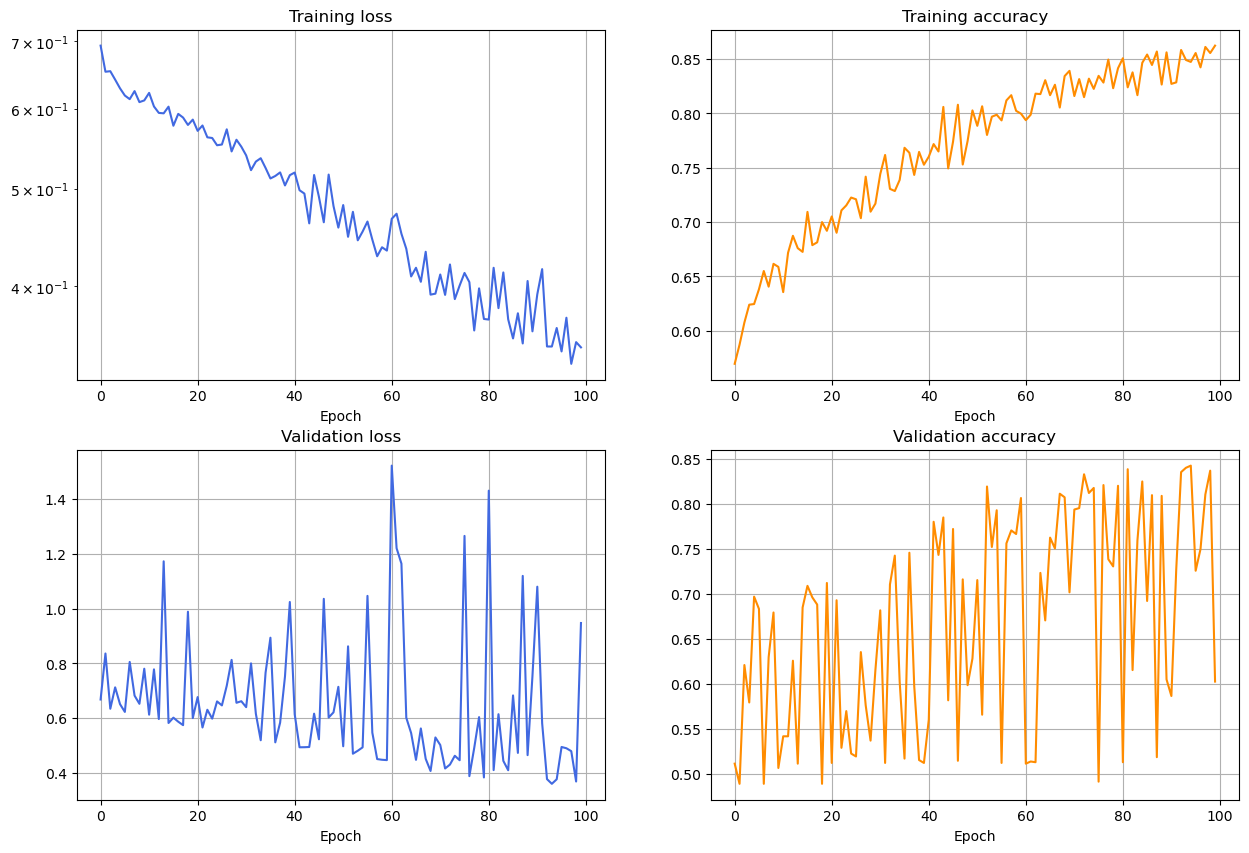

In [40]:
# plot training/validation loss and accuracy over training time
print(test(model_9, PSF_testing))
print(test(model_9, PSF_good_testing))
plot_model_results()

In [41]:
config = {'lr': 1e-4,
          'n_epochs': 100,
          'batch_size': 128}
# train
verbose = True # print metrics during training, False for no printing
train_losses, train_accs, val_losses, val_accs, best_model = train(model_9.cuda(),
                                                                   PSF_training,
                                                                   training_indices_1,
                                                                   validation_indices_1,
                                                                   config,
                                                                   verbose=verbose)

Epoch 5/100: (Train) Loss = 3.1134e-01, Acc = 0.8782, (Val) Loss = 3.5186e-01, Acc = 0.8480
Epoch 10/100: (Train) Loss = 3.0965e-01, Acc = 0.8766, (Val) Loss = 3.5446e-01, Acc = 0.8432
Epoch 15/100: (Train) Loss = 3.2109e-01, Acc = 0.8806, (Val) Loss = 7.3027e-01, Acc = 0.6248
Epoch 20/100: (Train) Loss = 3.1378e-01, Acc = 0.8816, (Val) Loss = 4.3744e-01, Acc = 0.7728
Epoch 25/100: (Train) Loss = 2.9490e-01, Acc = 0.8850, (Val) Loss = 3.5395e-01, Acc = 0.8320
Epoch 30/100: (Train) Loss = 2.9447e-01, Acc = 0.8840, (Val) Loss = 3.4433e-01, Acc = 0.8496
Epoch 35/100: (Train) Loss = 2.9130e-01, Acc = 0.8850, (Val) Loss = 3.3939e-01, Acc = 0.8560
Epoch 40/100: (Train) Loss = 2.9128e-01, Acc = 0.8858, (Val) Loss = 3.7295e-01, Acc = 0.8576
Epoch 45/100: (Train) Loss = 2.9261e-01, Acc = 0.8824, (Val) Loss = 3.9473e-01, Acc = 0.8016
Epoch 50/100: (Train) Loss = 2.8562e-01, Acc = 0.8870, (Val) Loss = 4.1924e-01, Acc = 0.8336
Epoch 55/100: (Train) Loss = 2.8646e-01, Acc = 0.8860, (Val) Loss = 3.8

0.8290735357990043
0.6391330706274628


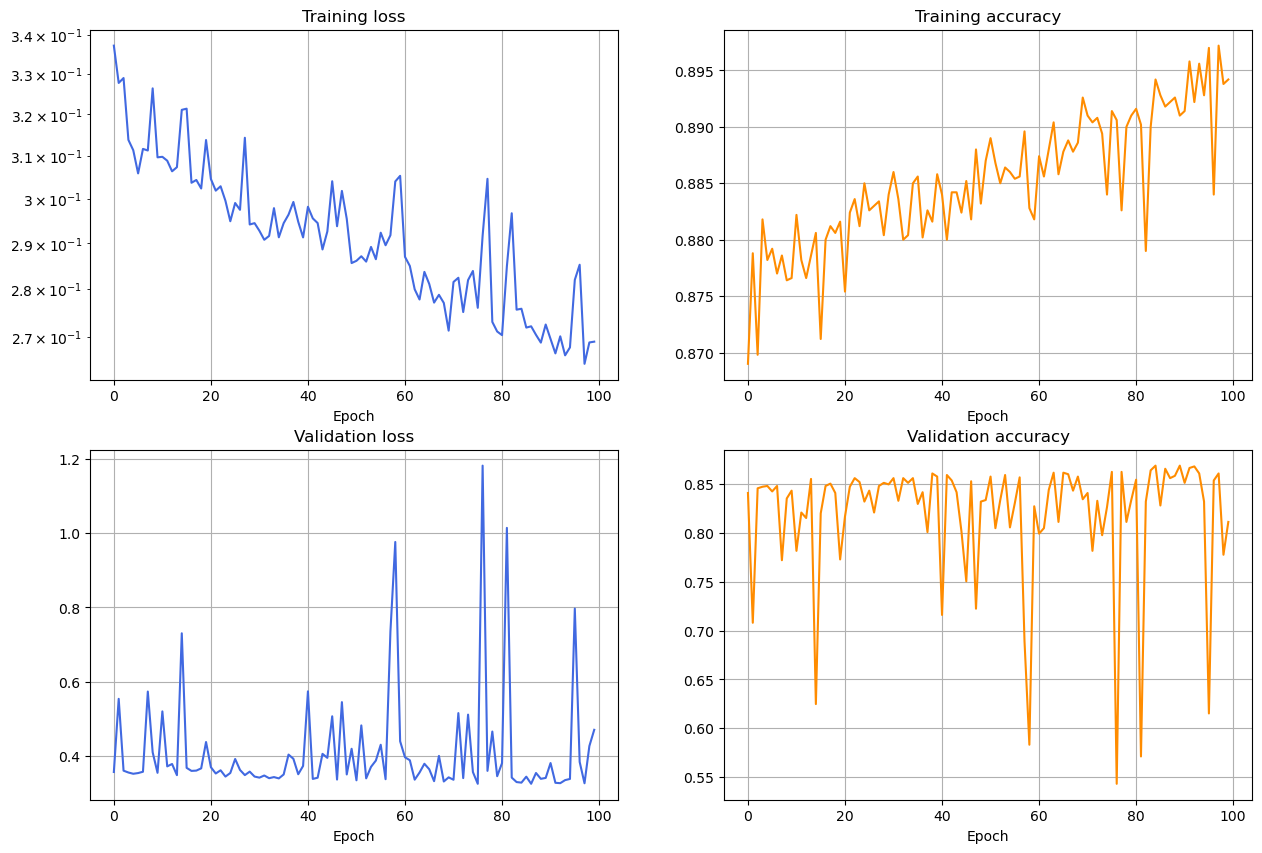

In [42]:
# plot training/validation loss and accuracy over training time
print(test(model_9, PSF_testing))
print(test(model_9, PSF_good_testing))
plot_model_results()

In [43]:
config = {'lr': 1e-5,
          'n_epochs': 100,
          'batch_size': 128}
# train
verbose = True # print metrics during training, False for no printing
train_losses, train_accs, val_losses, val_accs, best_model = train(model_9.cuda(),
                                                                   PSF_training,
                                                                   training_indices_1,
                                                                   validation_indices_1,
                                                                   config,
                                                                   verbose=verbose)

Epoch 5/100: (Train) Loss = 2.5557e-01, Acc = 0.8996, (Val) Loss = 3.1882e-01, Acc = 0.8632
Epoch 10/100: (Train) Loss = 2.5720e-01, Acc = 0.8988, (Val) Loss = 3.2090e-01, Acc = 0.8624
Epoch 15/100: (Train) Loss = 2.6126e-01, Acc = 0.8984, (Val) Loss = 3.1818e-01, Acc = 0.8672
Epoch 20/100: (Train) Loss = 2.5784e-01, Acc = 0.8990, (Val) Loss = 3.1969e-01, Acc = 0.8680
Epoch 25/100: (Train) Loss = 2.5831e-01, Acc = 0.8976, (Val) Loss = 3.1979e-01, Acc = 0.8600
Epoch 30/100: (Train) Loss = 2.5797e-01, Acc = 0.8980, (Val) Loss = 3.1927e-01, Acc = 0.8672
Epoch 35/100: (Train) Loss = 2.6159e-01, Acc = 0.8984, (Val) Loss = 3.1786e-01, Acc = 0.8576
Epoch 40/100: (Train) Loss = 2.5551e-01, Acc = 0.9000, (Val) Loss = 3.1728e-01, Acc = 0.8680
Epoch 45/100: (Train) Loss = 2.5390e-01, Acc = 0.8996, (Val) Loss = 3.1932e-01, Acc = 0.8656
Epoch 50/100: (Train) Loss = 2.5628e-01, Acc = 0.8962, (Val) Loss = 3.1978e-01, Acc = 0.8656
Epoch 55/100: (Train) Loss = 2.5367e-01, Acc = 0.8994, (Val) Loss = 3.1

0.8778523938391634
0.7414367990300091


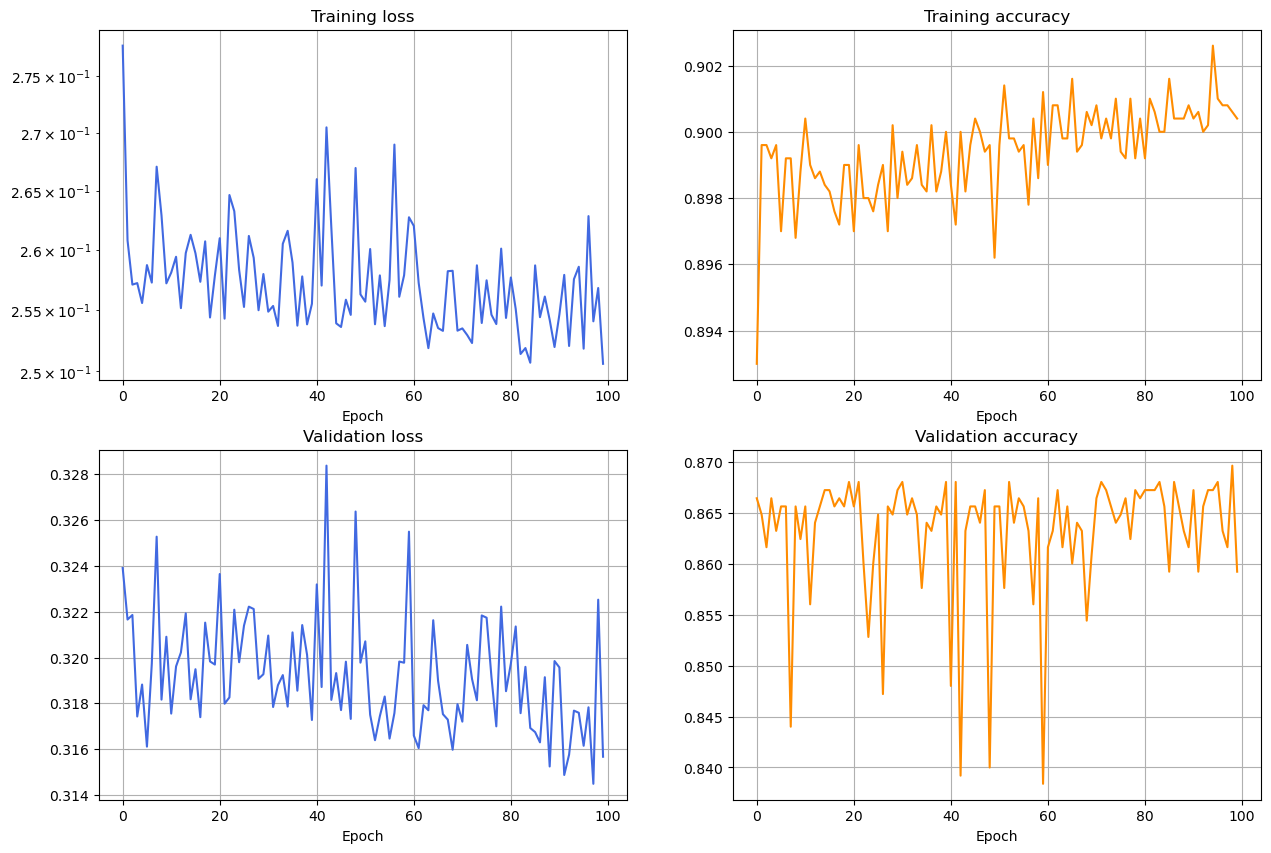

In [44]:
# plot training/validation loss and accuracy over training time
print(test(model_9, PSF_testing))
print(test(model_9, PSF_good_testing))
plot_model_results()

In [45]:
config = {'lr': 1e-6,
          'n_epochs': 100,
          'batch_size': 128}
# train
verbose = True # print metrics during training, False for no printing
train_losses, train_accs, val_losses, val_accs, best_model = train(model_9.cuda(),
                                                                   PSF_training,
                                                                   training_indices_2,
                                                                   validation_indices_1,
                                                                   config,
                                                                   verbose=verbose)

Epoch 5/100: (Train) Loss = 3.0402e-01, Acc = 0.8802, (Val) Loss = 3.1619e-01, Acc = 0.8680
Epoch 10/100: (Train) Loss = 3.0128e-01, Acc = 0.8806, (Val) Loss = 3.1659e-01, Acc = 0.8672
Epoch 15/100: (Train) Loss = 3.0231e-01, Acc = 0.8808, (Val) Loss = 3.1680e-01, Acc = 0.8680
Epoch 20/100: (Train) Loss = 3.0231e-01, Acc = 0.8806, (Val) Loss = 3.1613e-01, Acc = 0.8664
Epoch 25/100: (Train) Loss = 3.0462e-01, Acc = 0.8820, (Val) Loss = 3.1402e-01, Acc = 0.8672
Epoch 30/100: (Train) Loss = 3.0827e-01, Acc = 0.8810, (Val) Loss = 3.1528e-01, Acc = 0.8664
Epoch 35/100: (Train) Loss = 3.0532e-01, Acc = 0.8816, (Val) Loss = 3.1501e-01, Acc = 0.8672
Epoch 40/100: (Train) Loss = 3.0014e-01, Acc = 0.8818, (Val) Loss = 3.1570e-01, Acc = 0.8672
Epoch 45/100: (Train) Loss = 3.0227e-01, Acc = 0.8820, (Val) Loss = 3.1571e-01, Acc = 0.8680
Epoch 50/100: (Train) Loss = 2.9757e-01, Acc = 0.8818, (Val) Loss = 3.1463e-01, Acc = 0.8680
Epoch 55/100: (Train) Loss = 3.0403e-01, Acc = 0.8816, (Val) Loss = 3.1

0.8842003274197321
0.7252197635647166


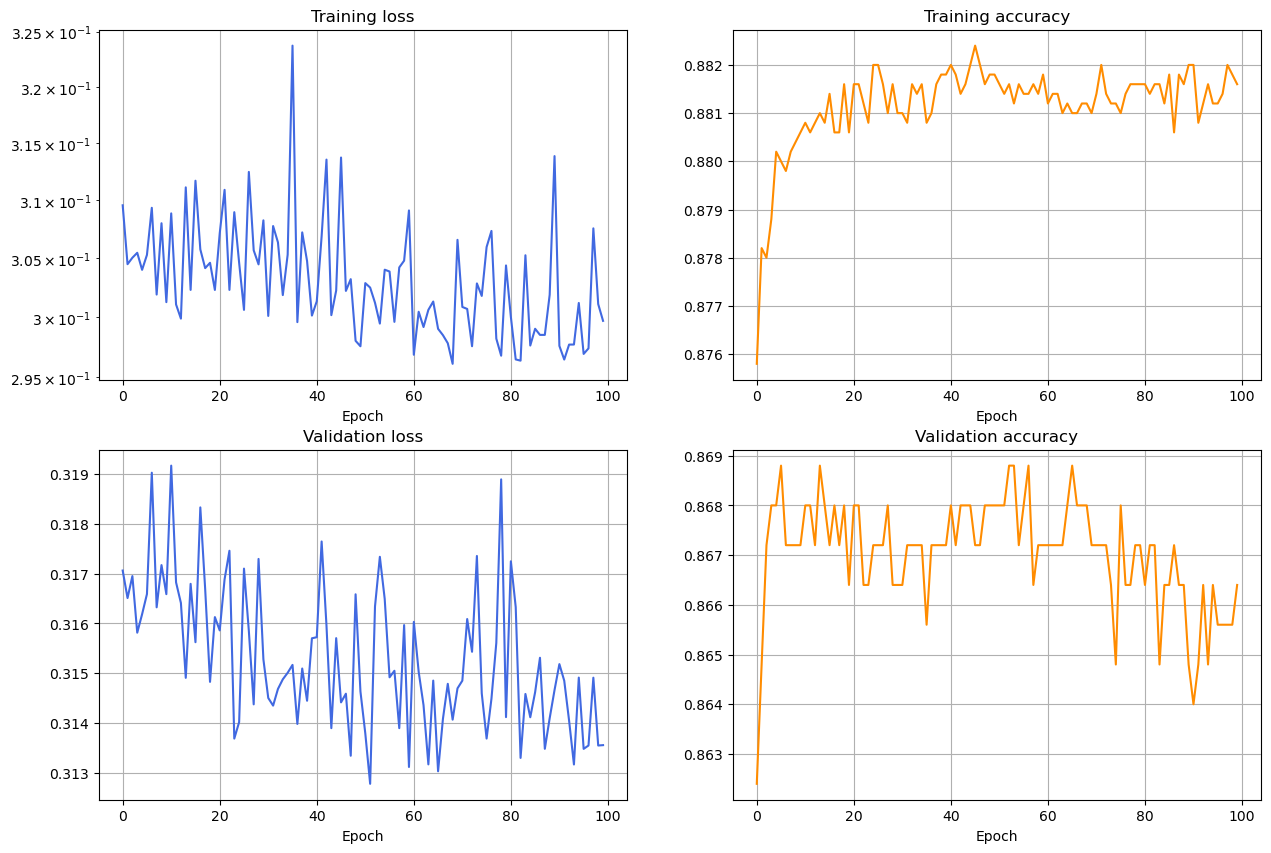

In [46]:
# plot training/validation loss and accuracy over training time
print(test(model_9, PSF_testing))
print(test(model_9, PSF_good_testing))
plot_model_results()

In [48]:
config = {'lr': 1e-4,
          'n_epochs': 100,
          'batch_size': 128}
# train
verbose = True # print metrics during training, False for no printing
train_losses, train_accs, val_losses, val_accs, best_model = train(model_9.cuda(),
                                                                   PSF_training,
                                                                   training_indices_2,
                                                                   validation_indices_1,
                                                                   config,
                                                                   verbose=verbose)

Epoch 5/100: (Train) Loss = 3.2208e-01, Acc = 0.8722, (Val) Loss = 3.7632e-01, Acc = 0.8216
Epoch 10/100: (Train) Loss = 2.9493e-01, Acc = 0.8818, (Val) Loss = 3.6916e-01, Acc = 0.8584
Epoch 15/100: (Train) Loss = 2.9270e-01, Acc = 0.8822, (Val) Loss = 4.3820e-01, Acc = 0.8224
Epoch 20/100: (Train) Loss = 2.8603e-01, Acc = 0.8862, (Val) Loss = 4.2483e-01, Acc = 0.7888
Epoch 25/100: (Train) Loss = 2.8874e-01, Acc = 0.8850, (Val) Loss = 3.1239e-01, Acc = 0.8504
Epoch 30/100: (Train) Loss = 2.9089e-01, Acc = 0.8830, (Val) Loss = 3.1146e-01, Acc = 0.8560
Epoch 35/100: (Train) Loss = 2.7804e-01, Acc = 0.8874, (Val) Loss = 3.0805e-01, Acc = 0.8608
Epoch 40/100: (Train) Loss = 2.7326e-01, Acc = 0.8924, (Val) Loss = 3.7334e-01, Acc = 0.8200
Epoch 45/100: (Train) Loss = 2.8955e-01, Acc = 0.8784, (Val) Loss = 4.6211e-01, Acc = 0.8048
Epoch 50/100: (Train) Loss = 2.7097e-01, Acc = 0.8950, (Val) Loss = 4.6504e-01, Acc = 0.7712
Epoch 55/100: (Train) Loss = 2.8257e-01, Acc = 0.8860, (Val) Loss = 1.2

0.8827636898199192
0.7487117308275235


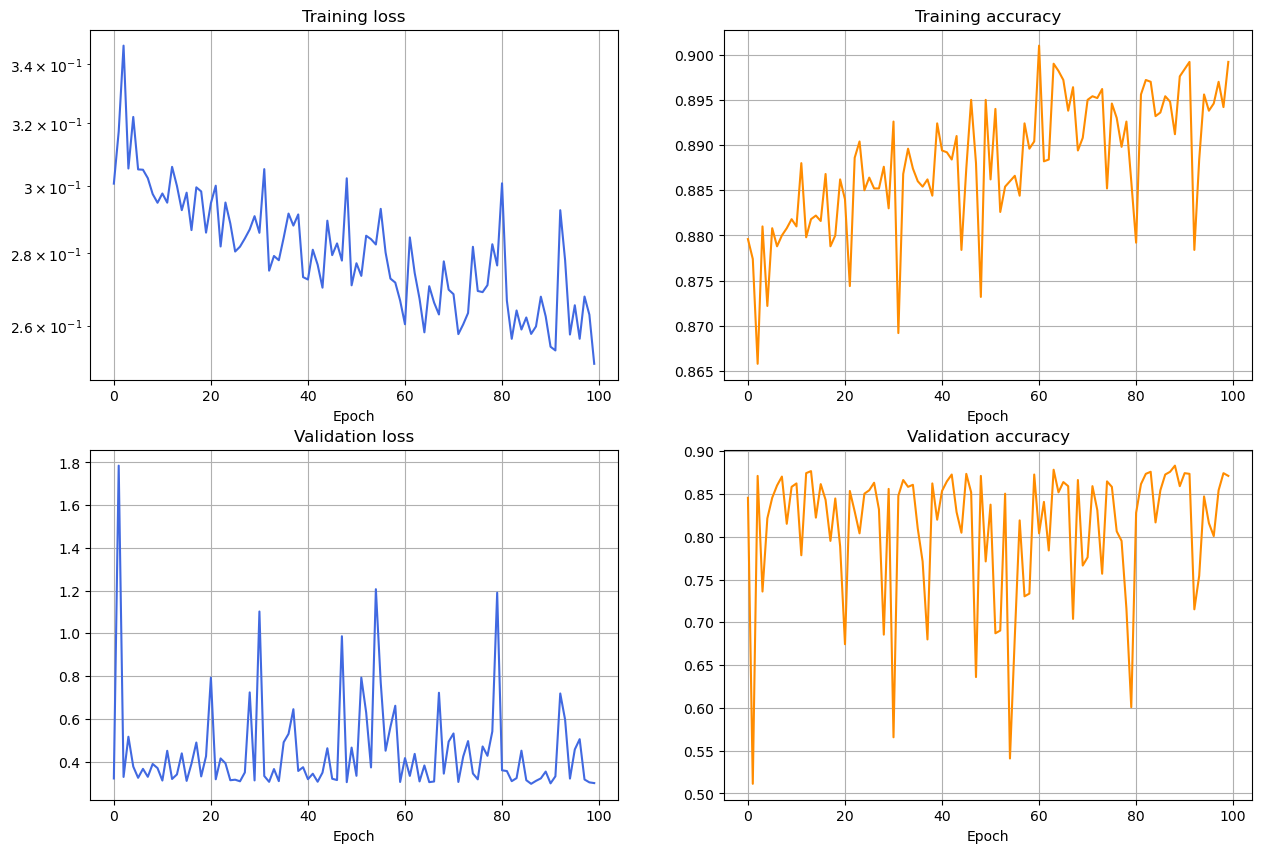

In [49]:
# plot training/validation loss and accuracy over training time
print(test(model_9, PSF_testing))
print(test(model_9, PSF_good_testing))
plot_model_results()

In [50]:
config = {'lr': 1e-4,
          'n_epochs': 100,
          'batch_size': 128}
# train
verbose = True # print metrics during training, False for no printing
train_losses, train_accs, val_losses, val_accs, best_model = train(model_9.cuda(),
                                                                   PSF_training,
                                                                   training_indices_2,
                                                                   validation_indices_1,
                                                                   config,
                                                                   verbose=verbose)

Epoch 5/100: (Train) Loss = 2.4632e-01, Acc = 0.9054, (Val) Loss = 5.1390e-01, Acc = 0.7960
Epoch 10/100: (Train) Loss = 2.8082e-01, Acc = 0.8840, (Val) Loss = 7.1360e-01, Acc = 0.7224
Epoch 15/100: (Train) Loss = 2.4944e-01, Acc = 0.9038, (Val) Loss = 1.0659e+00, Acc = 0.6280
Epoch 20/100: (Train) Loss = 2.4816e-01, Acc = 0.9040, (Val) Loss = 5.2242e-01, Acc = 0.7960
Epoch 25/100: (Train) Loss = 2.6878e-01, Acc = 0.8868, (Val) Loss = 2.9416e-01, Acc = 0.8784
Epoch 30/100: (Train) Loss = 2.5694e-01, Acc = 0.8988, (Val) Loss = 3.0825e-01, Acc = 0.8784
Epoch 35/100: (Train) Loss = 2.4516e-01, Acc = 0.9014, (Val) Loss = 4.6817e-01, Acc = 0.8240
Epoch 40/100: (Train) Loss = 2.3882e-01, Acc = 0.9042, (Val) Loss = 2.8873e-01, Acc = 0.8712
Epoch 45/100: (Train) Loss = 2.6678e-01, Acc = 0.8910, (Val) Loss = 6.1298e-01, Acc = 0.7688
Epoch 50/100: (Train) Loss = 2.4795e-01, Acc = 0.8984, (Val) Loss = 4.1612e-01, Acc = 0.8440
Epoch 55/100: (Train) Loss = 2.3247e-01, Acc = 0.9100, (Val) Loss = 4.6

0.8668938558684975
0.6482267353743558


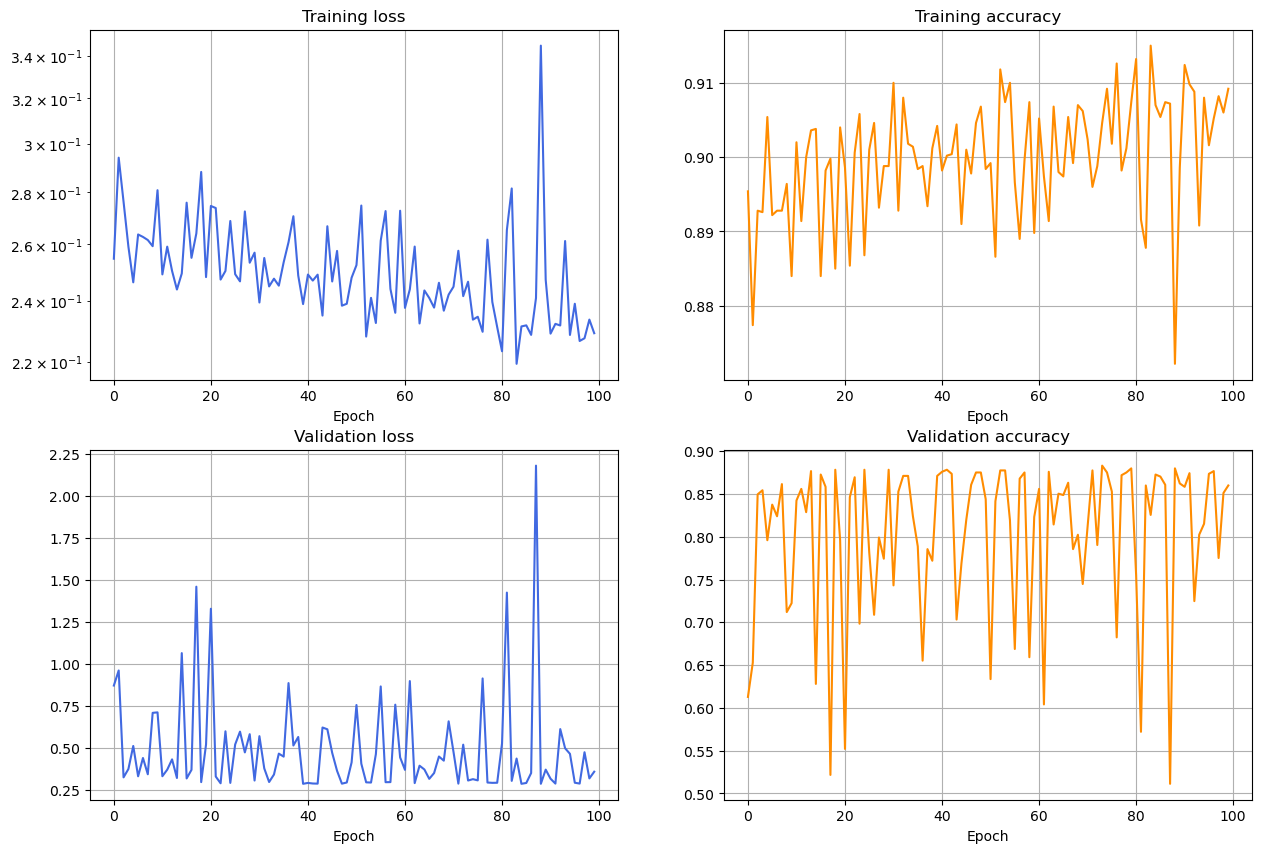

In [51]:
# plot training/validation loss and accuracy over training time
print(test(model_9, PSF_testing))
print(test(model_9, PSF_good_testing))
plot_model_results()

In [52]:
config = {'lr': 1e-5,
          'n_epochs': 100,
          'batch_size': 128}
# train
verbose = True # print metrics during training, False for no printing
train_losses, train_accs, val_losses, val_accs, best_model = train(model_9.cuda(),
                                                                   PSF_training,
                                                                   training_indices_2,
                                                                   validation_indices_1,
                                                                   config,
                                                                   verbose=verbose)

Epoch 5/100: (Train) Loss = 2.0822e-01, Acc = 0.9202, (Val) Loss = 2.9372e-01, Acc = 0.8776
Epoch 10/100: (Train) Loss = 2.0756e-01, Acc = 0.9192, (Val) Loss = 2.8619e-01, Acc = 0.8768
Epoch 15/100: (Train) Loss = 2.1152e-01, Acc = 0.9212, (Val) Loss = 2.8450e-01, Acc = 0.8736
Epoch 20/100: (Train) Loss = 2.0647e-01, Acc = 0.9202, (Val) Loss = 2.8531e-01, Acc = 0.8760
Epoch 25/100: (Train) Loss = 2.0818e-01, Acc = 0.9200, (Val) Loss = 2.8513e-01, Acc = 0.8712
Epoch 30/100: (Train) Loss = 2.0679e-01, Acc = 0.9198, (Val) Loss = 2.8499e-01, Acc = 0.8744
Epoch 35/100: (Train) Loss = 2.1749e-01, Acc = 0.9214, (Val) Loss = 2.9858e-01, Acc = 0.8840
Epoch 40/100: (Train) Loss = 2.0660e-01, Acc = 0.9202, (Val) Loss = 2.8756e-01, Acc = 0.8744
Epoch 45/100: (Train) Loss = 2.0419e-01, Acc = 0.9202, (Val) Loss = 2.8762e-01, Acc = 0.8760
Epoch 50/100: (Train) Loss = 2.0707e-01, Acc = 0.9218, (Val) Loss = 2.9110e-01, Acc = 0.8720
Epoch 55/100: (Train) Loss = 2.0633e-01, Acc = 0.9198, (Val) Loss = 2.8

0.895125455213658
0.7124128523795089


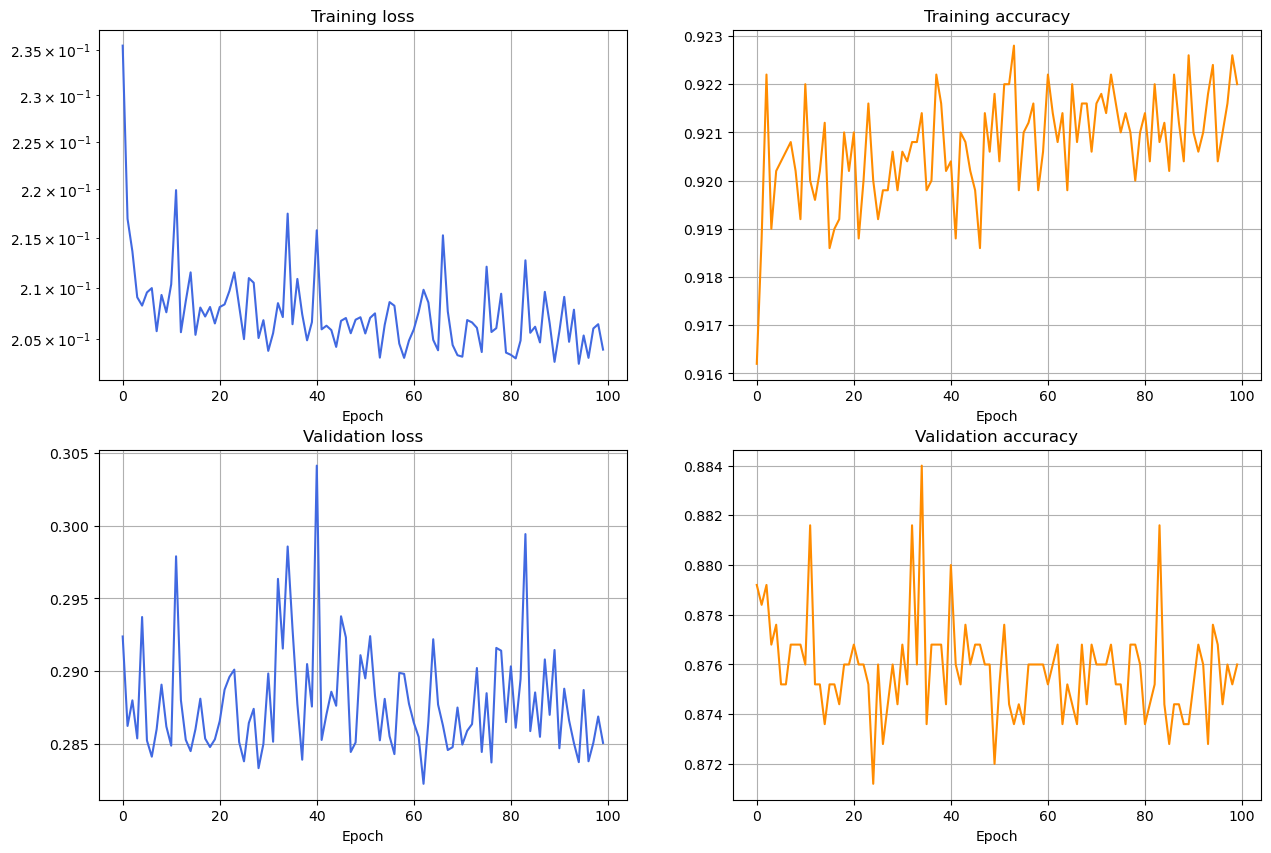

In [53]:
# plot training/validation loss and accuracy over training time
print(test(model_9, PSF_testing))
print(test(model_9, PSF_good_testing))
plot_model_results()

#### Current Runs

In [54]:
# data
# you can try playing around with more or less training data
N_training_examples = 50000 # 100 examples per class
N_validation_examples = 2500 # 100 examples per class
random_seed = 1 # random seed for reproducibility
np.random.seed(random_seed)
all_train_indices = np.random.choice(np.arange(len(PSF_training)),
                               size=2*N_training_examples+N_validation_examples)
# Make two unique training/validation sets for change partway through training if desired
all_train_indices_1 = all_train_indices[:int(len(all_train_indices)/2)]
all_train_indices_2 = all_train_indices[int(len(all_train_indices)/2):]
training_indices_1 = all_train_indices_1[:N_training_examples]
validation_indices_1 = all_train_indices_1[N_training_examples:]
training_indices_2 = all_train_indices_2[:N_training_examples]
validation_indices_2 = all_train_indices_2[N_training_examples:]

config = {'lr': 1e-5,
          'n_epochs': 20,
          'batch_size': 128}
# train
verbose = True # print metrics during training, False for no printing
train_losses, train_accs, val_losses, val_accs, best_model = train(model_9.cuda(),
                                                                   PSF_training,
                                                                   training_indices_1,
                                                                   validation_indices_1,
                                                                   config,
                                                                   verbose=verbose)

Epoch 1/20: (Train) Loss = 2.5402e-01, Acc = 0.8994, (Val) Loss = 2.6138e-01, Acc = 0.9080
Epoch 2/20: (Train) Loss = 2.5276e-01, Acc = 0.9001, (Val) Loss = 2.6111e-01, Acc = 0.9032
Epoch 3/20: (Train) Loss = 2.5172e-01, Acc = 0.9002, (Val) Loss = 2.5896e-01, Acc = 0.9056
Epoch 4/20: (Train) Loss = 2.5073e-01, Acc = 0.9003, (Val) Loss = 2.5634e-01, Acc = 0.9112
Epoch 5/20: (Train) Loss = 2.5018e-01, Acc = 0.9015, (Val) Loss = 2.5656e-01, Acc = 0.9048
Epoch 6/20: (Train) Loss = 2.4952e-01, Acc = 0.9014, (Val) Loss = 2.6011e-01, Acc = 0.9048
Epoch 7/20: (Train) Loss = 2.4910e-01, Acc = 0.9017, (Val) Loss = 2.5535e-01, Acc = 0.9112
Epoch 8/20: (Train) Loss = 2.4859e-01, Acc = 0.9021, (Val) Loss = 2.5782e-01, Acc = 0.9088
Epoch 9/20: (Train) Loss = 2.4816e-01, Acc = 0.9017, (Val) Loss = 2.5664e-01, Acc = 0.9080
Epoch 10/20: (Train) Loss = 2.4776e-01, Acc = 0.9023, (Val) Loss = 2.5208e-01, Acc = 0.9104
Epoch 11/20: (Train) Loss = 2.4721e-01, Acc = 0.9026, (Val) Loss = 2.5716e-01, Acc = 0.90

0.8985332932411213
0.7249924219460443


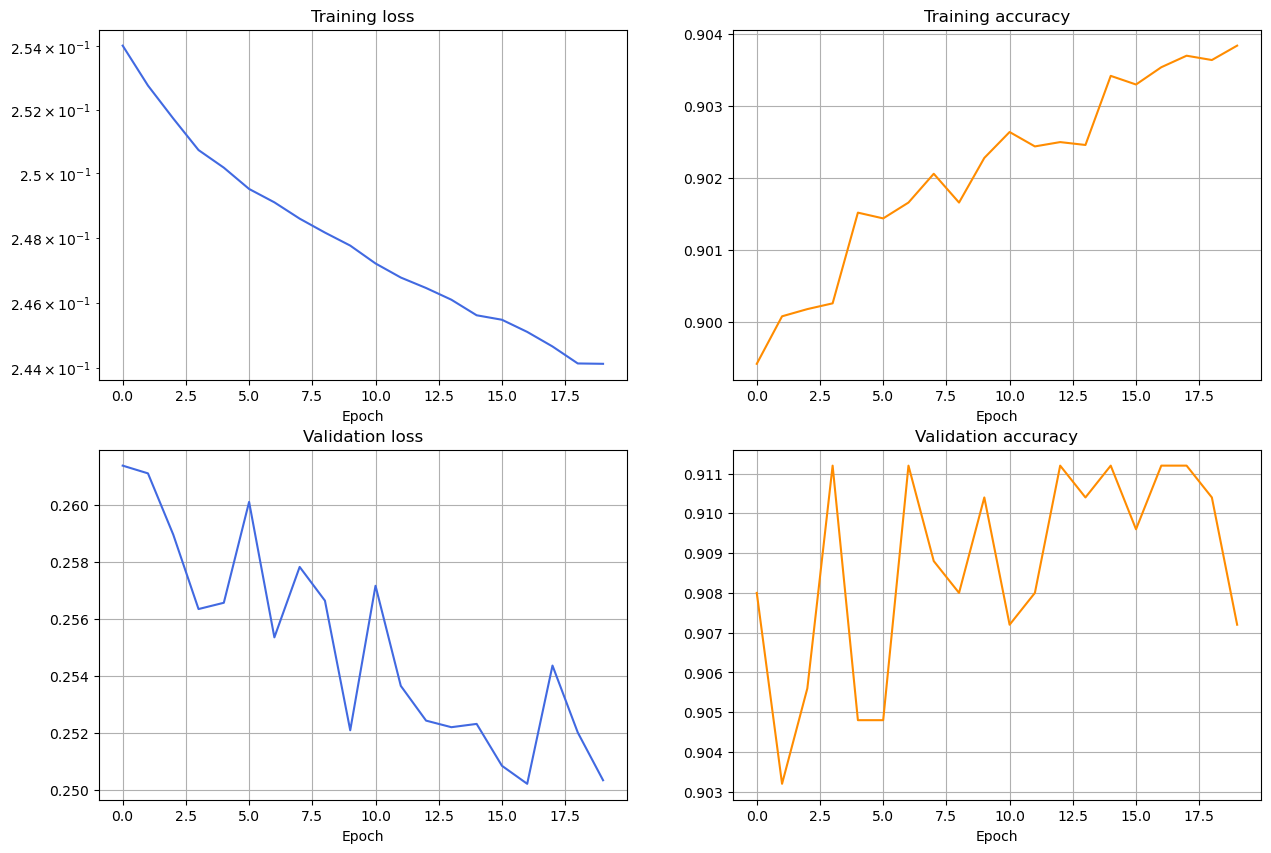

In [56]:
# plot training/validation loss and accuracy over training time
print(test(best_model, PSF_testing))
print(test(best_model, PSF_good_testing))
plot_model_results()

In [57]:
torch.save(model_9, 'Models/model9.pt')

### Model 10

In [59]:
# metrics visualization

# data
# you can try playing around with more or less training data
N_training_examples = 20000 # 100 examples per class
N_validation_examples = 2000 # 100 examples per class
random_seed = 1 # random seed for reproducibility
np.random.seed(random_seed)
all_train_indices = np.random.choice(np.arange(len(PSF_training)),
                               size=2*N_training_examples+N_validation_examples)
# Make two unique training/validation sets for change partway through training if desired
all_train_indices_1 = all_train_indices[:int(len(all_train_indices)/2)]
all_train_indices_2 = all_train_indices[int(len(all_train_indices)/2):]
training_indices_1 = all_train_indices_1[:N_training_examples]
validation_indices_1 = all_train_indices_1[N_training_examples:]
training_indices_2 = all_train_indices_2[:N_training_examples]
validation_indices_2 = all_train_indices_2[N_training_examples:]

# configuration parameters, you can play around with these
pooling = 'max' # 'max' or 'mean'

if pooling == 'max':
    pool_fcn = nn.AdaptiveMaxPool2d((1, 1))
else:
    pool_fcn = nn.AdaptiveAvgPool2d((1, 1))
# model
# your model will have length(channel_widths)-1 layers
channel_widths = [1, 64, 128, 128, 256, 256, 512] # must start with a 1 and be at least length--2
linear_sizes = [512, 64]
kernel = 4
model_10 = CNN_FC(channel_widths, linear_sizes, kernel, pool_fcn)

In [60]:
config = {'lr': 1e-3,
          'n_epochs': 100,
          'batch_size': 512}
# train
verbose = True # print metrics during training, False for no printing
train_losses, train_accs, val_losses, val_accs, best_model = train(model_10.cuda(),
                                                                   PSF_training,
                                                                   training_indices_1,
                                                                   validation_indices_1,
                                                                   config,
                                                                   verbose=verbose)

Epoch 5/100: (Train) Loss = 6.1844e-01, Acc = 0.6442, (Val) Loss = 6.3341e-01, Acc = 0.6930
Epoch 10/100: (Train) Loss = 5.5443e-01, Acc = 0.7176, (Val) Loss = 5.8387e-01, Acc = 0.7050
Epoch 15/100: (Train) Loss = 5.3429e-01, Acc = 0.7182, (Val) Loss = 6.0582e-01, Acc = 0.5740
Epoch 20/100: (Train) Loss = 4.4213e-01, Acc = 0.7977, (Val) Loss = 4.3252e-01, Acc = 0.8260
Epoch 25/100: (Train) Loss = 4.1901e-01, Acc = 0.8152, (Val) Loss = 5.3551e-01, Acc = 0.7470
Epoch 30/100: (Train) Loss = 4.0097e-01, Acc = 0.8180, (Val) Loss = 4.1279e-01, Acc = 0.8290
Epoch 35/100: (Train) Loss = 3.5465e-01, Acc = 0.8486, (Val) Loss = 4.6894e-01, Acc = 0.7910
Epoch 40/100: (Train) Loss = 3.9988e-01, Acc = 0.8201, (Val) Loss = 3.7015e-01, Acc = 0.8200
Epoch 45/100: (Train) Loss = 3.4438e-01, Acc = 0.8558, (Val) Loss = 3.7482e-01, Acc = 0.8050
Epoch 50/100: (Train) Loss = 3.2711e-01, Acc = 0.8642, (Val) Loss = 3.1772e-01, Acc = 0.8730
Epoch 55/100: (Train) Loss = 3.2587e-01, Acc = 0.8611, (Val) Loss = 3.2

0.891684207009455
0.7521976356471658


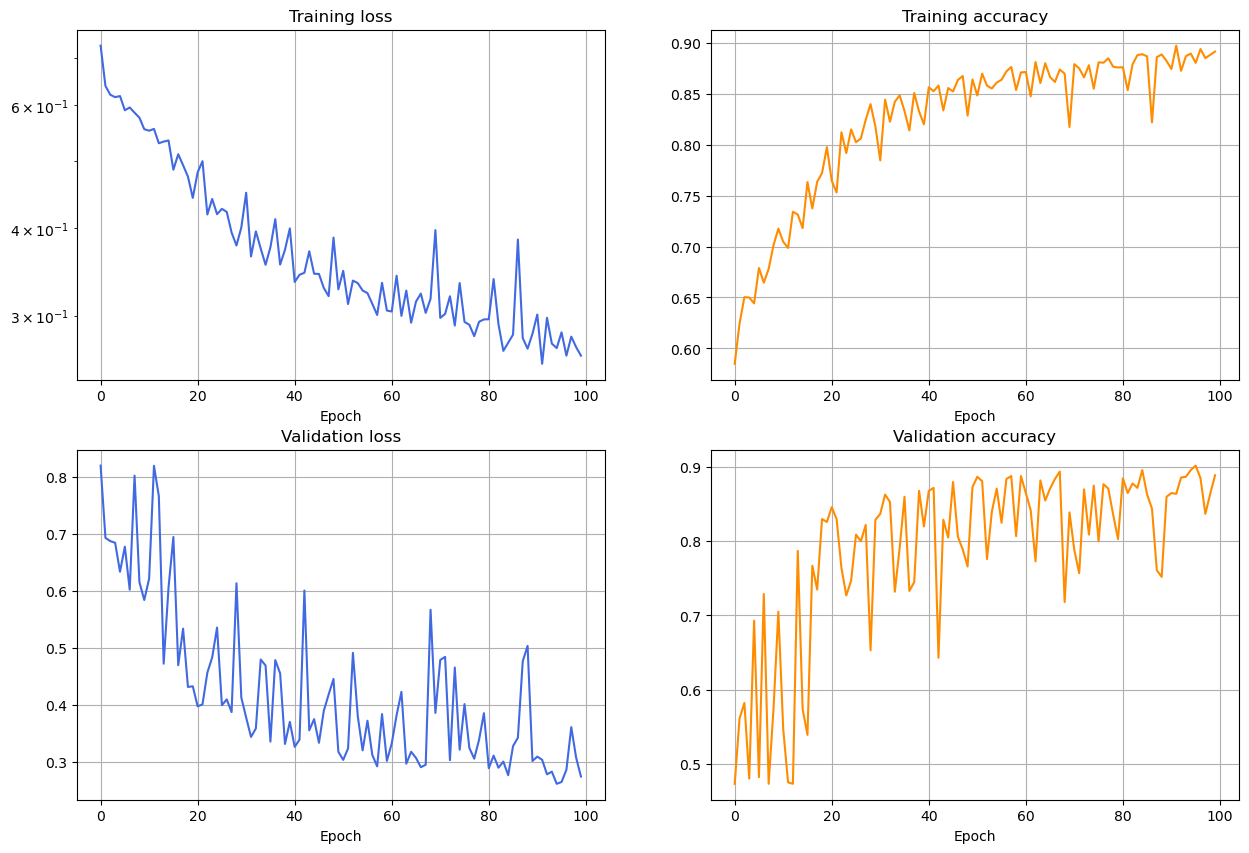

In [61]:
# plot training/validation loss and accuracy over training time
print(test(model_10, PSF_testing))
print(test(model_10, PSF_good_testing))
plot_model_results()

In [62]:
config = {'lr': 1e-4,
          'n_epochs': 100,
          'batch_size': 512}
# train
verbose = True # print metrics during training, False for no printing
train_losses, train_accs, val_losses, val_accs, best_model = train(model_10.cuda(),
                                                                   PSF_training,
                                                                   training_indices_2,
                                                                   validation_indices_1,
                                                                   config,
                                                                   verbose=verbose)

Epoch 5/100: (Train) Loss = 2.4819e-01, Acc = 0.9038, (Val) Loss = 2.5410e-01, Acc = 0.8980
Epoch 10/100: (Train) Loss = 2.4555e-01, Acc = 0.9041, (Val) Loss = 2.5643e-01, Acc = 0.8970
Epoch 15/100: (Train) Loss = 2.4443e-01, Acc = 0.9043, (Val) Loss = 2.4900e-01, Acc = 0.8980
Epoch 20/100: (Train) Loss = 2.4321e-01, Acc = 0.9060, (Val) Loss = 2.4813e-01, Acc = 0.9010
Epoch 25/100: (Train) Loss = 2.4668e-01, Acc = 0.9052, (Val) Loss = 2.6764e-01, Acc = 0.8820
Epoch 30/100: (Train) Loss = 2.3737e-01, Acc = 0.9061, (Val) Loss = 2.4739e-01, Acc = 0.8990
Epoch 35/100: (Train) Loss = 2.3881e-01, Acc = 0.9069, (Val) Loss = 2.5940e-01, Acc = 0.8880
Epoch 40/100: (Train) Loss = 2.3509e-01, Acc = 0.9078, (Val) Loss = 2.4553e-01, Acc = 0.8980
Epoch 45/100: (Train) Loss = 2.3889e-01, Acc = 0.9074, (Val) Loss = 2.4882e-01, Acc = 0.9010
Epoch 50/100: (Train) Loss = 2.3912e-01, Acc = 0.9086, (Val) Loss = 2.4504e-01, Acc = 0.9000
Epoch 55/100: (Train) Loss = 2.3275e-01, Acc = 0.9083, (Val) Loss = 2.4

0.8991012662456984
0.7224158836010912


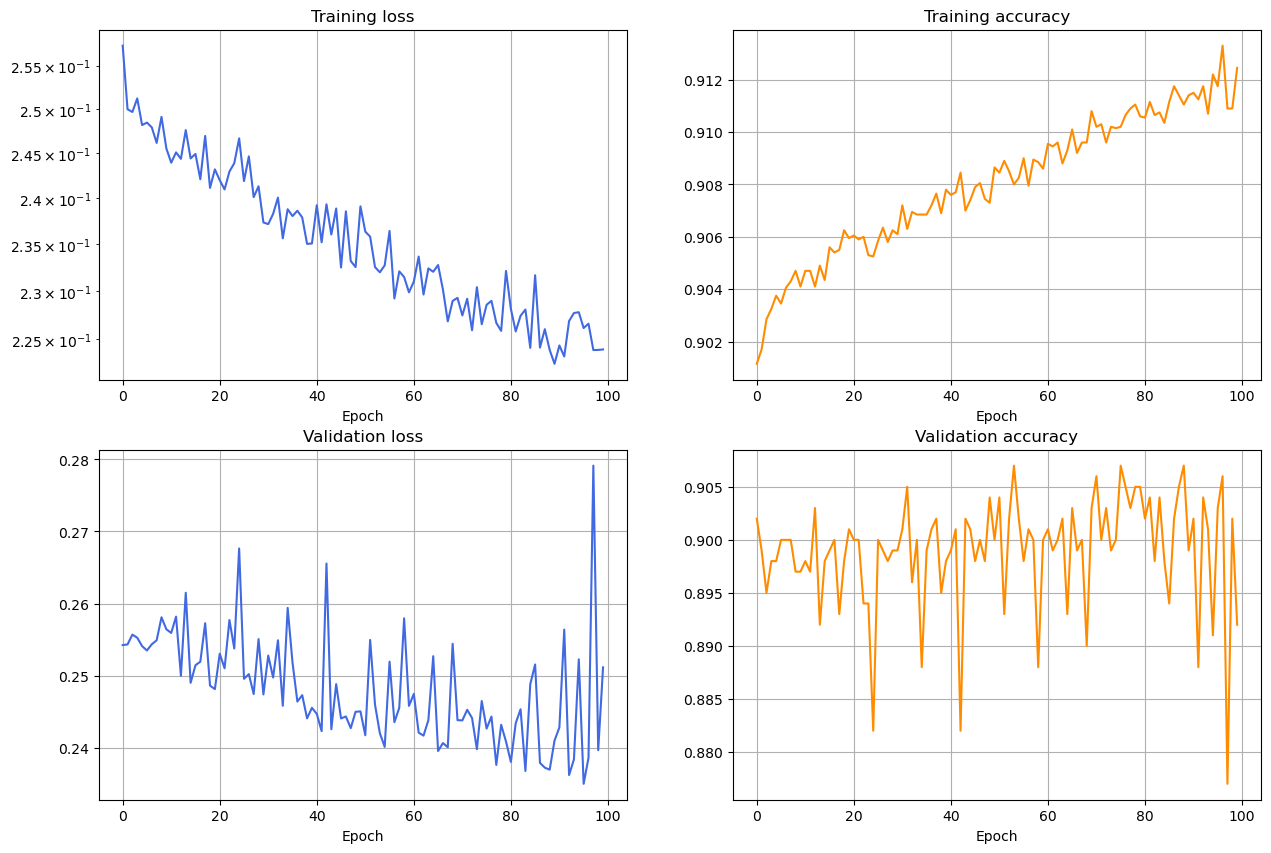

In [63]:
# plot training/validation loss and accuracy over training time
print(test(model_10, PSF_testing))
print(test(model_10, PSF_good_testing))
plot_model_results()

In [ ]:
torch.save(model_10, 'Models/model10.pt')

### Model 11

In [65]:
# metrics visualization

# data
# you can try playing around with more or less training data
N_training_examples = 20000 # 100 examples per class
N_validation_examples = 2000 # 100 examples per class
random_seed = 1 # random seed for reproducibility
np.random.seed(random_seed)
all_train_indices = np.random.choice(np.arange(len(PSF_training)),
                               size=2*N_training_examples+N_validation_examples)
# Make two unique training/validation sets for change partway through training if desired
all_train_indices_1 = all_train_indices[:int(len(all_train_indices)/2)]
all_train_indices_2 = all_train_indices[int(len(all_train_indices)/2):]
training_indices_1 = all_train_indices_1[:N_training_examples]
validation_indices_1 = all_train_indices_1[N_training_examples:]
training_indices_2 = all_train_indices_2[:N_training_examples]
validation_indices_2 = all_train_indices_2[N_training_examples:]

# configuration parameters, you can play around with these
pooling = 'max' # 'max' or 'mean'

if pooling == 'max':
    pool_fcn = nn.AdaptiveMaxPool2d((1, 1))
else:
    pool_fcn = nn.AdaptiveAvgPool2d((1, 1))
# model
# your model will have length(channel_widths)-1 layers
channel_widths = [1, 64, 128, 128, 256, 256, 512, 512] # must start with a 1 and be at least length--2
linear_sizes = [1024, 64]
kernel = 3
model_11 = CNN_FC(channel_widths, linear_sizes, kernel, pool_fcn)

In [66]:
config = {'lr': 1e-3,
          'n_epochs': 100,
          'batch_size': 512}
# train
verbose = True # print metrics during training, False for no printing
train_losses, train_accs, val_losses, val_accs, best_model = train(model_11.cuda(),
                                                                   PSF_training,
                                                                   training_indices_1,
                                                                   validation_indices_1,
                                                                   config,
                                                                   verbose=verbose)

Epoch 5/100: (Train) Loss = 6.2218e-01, Acc = 0.6471, (Val) Loss = 6.2323e-01, Acc = 0.7240
Epoch 10/100: (Train) Loss = 5.9651e-01, Acc = 0.6866, (Val) Loss = 6.5222e-01, Acc = 0.5140
Epoch 15/100: (Train) Loss = 5.5395e-01, Acc = 0.7228, (Val) Loss = 5.6237e-01, Acc = 0.6680
Epoch 20/100: (Train) Loss = 5.3940e-01, Acc = 0.7409, (Val) Loss = 5.4307e-01, Acc = 0.6810
Epoch 25/100: (Train) Loss = 4.8176e-01, Acc = 0.7661, (Val) Loss = 6.0781e-01, Acc = 0.6040
Epoch 30/100: (Train) Loss = 4.7056e-01, Acc = 0.7734, (Val) Loss = 4.1446e-01, Acc = 0.8300
Epoch 35/100: (Train) Loss = 4.5345e-01, Acc = 0.7916, (Val) Loss = 6.0681e-01, Acc = 0.6480
Epoch 40/100: (Train) Loss = 3.9862e-01, Acc = 0.8260, (Val) Loss = 3.6291e-01, Acc = 0.8510
Epoch 45/100: (Train) Loss = 3.8015e-01, Acc = 0.8345, (Val) Loss = 3.4914e-01, Acc = 0.8660
Epoch 50/100: (Train) Loss = 3.9053e-01, Acc = 0.8269, (Val) Loss = 3.5750e-01, Acc = 0.8360
Epoch 55/100: (Train) Loss = 3.8463e-01, Acc = 0.8410, (Val) Loss = 3.3

0.6058935551769069
0.6166262503789027


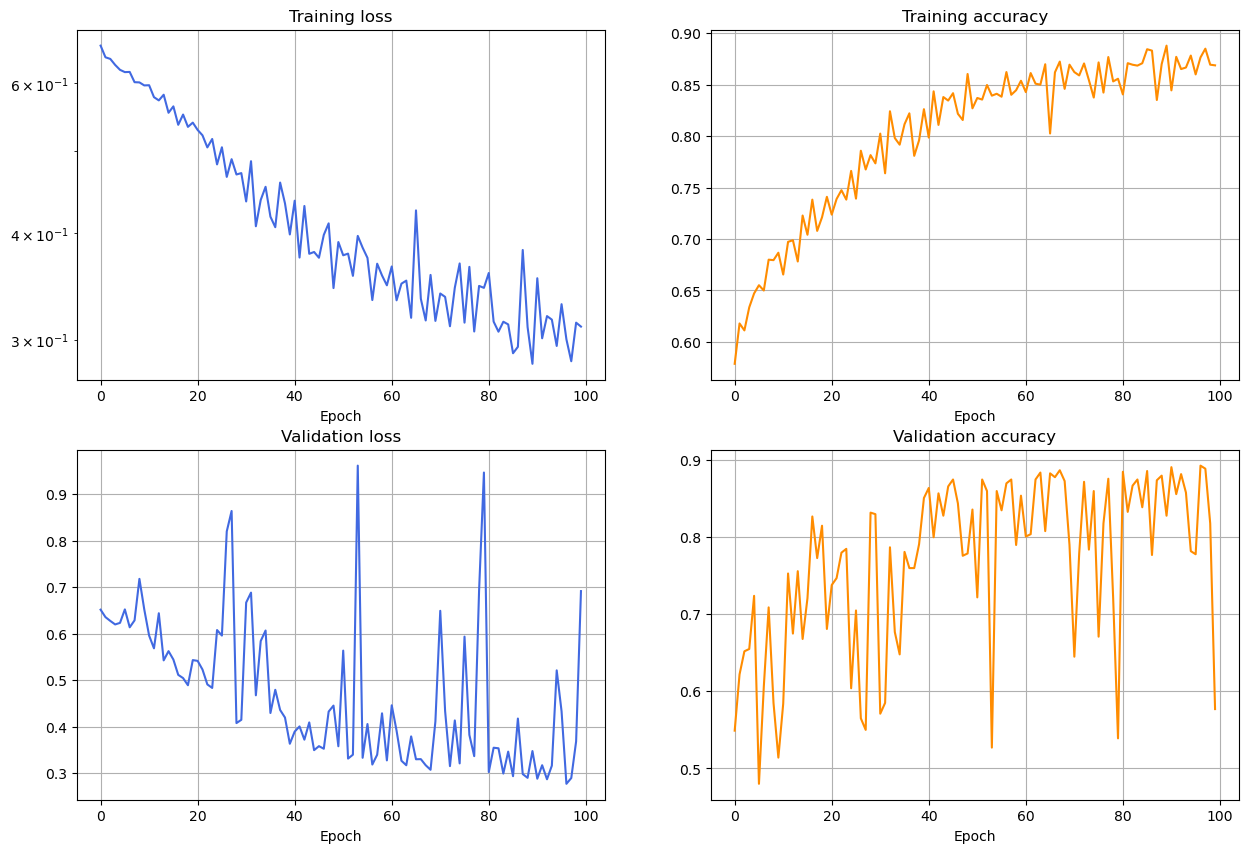

In [68]:
# plot training/validation loss and accuracy over training time
print(test(model_11, PSF_testing))
print(test(model_11, PSF_good_testing))
plot_model_results()

In [69]:
config = {'lr': 1e-4,
          'n_epochs': 5,
          'batch_size': 512}
# train
verbose = False # print metrics during training, False for no printing
train_losses, train_accs, val_losses, val_accs, best_model = train(model_11.cuda(),
                                                                   PSF_training,
                                                                   training_indices_1,
                                                                   validation_indices_1,
                                                                   config,
                                                                   verbose=verbose)

0.8921853596605526
0.7293876932403759


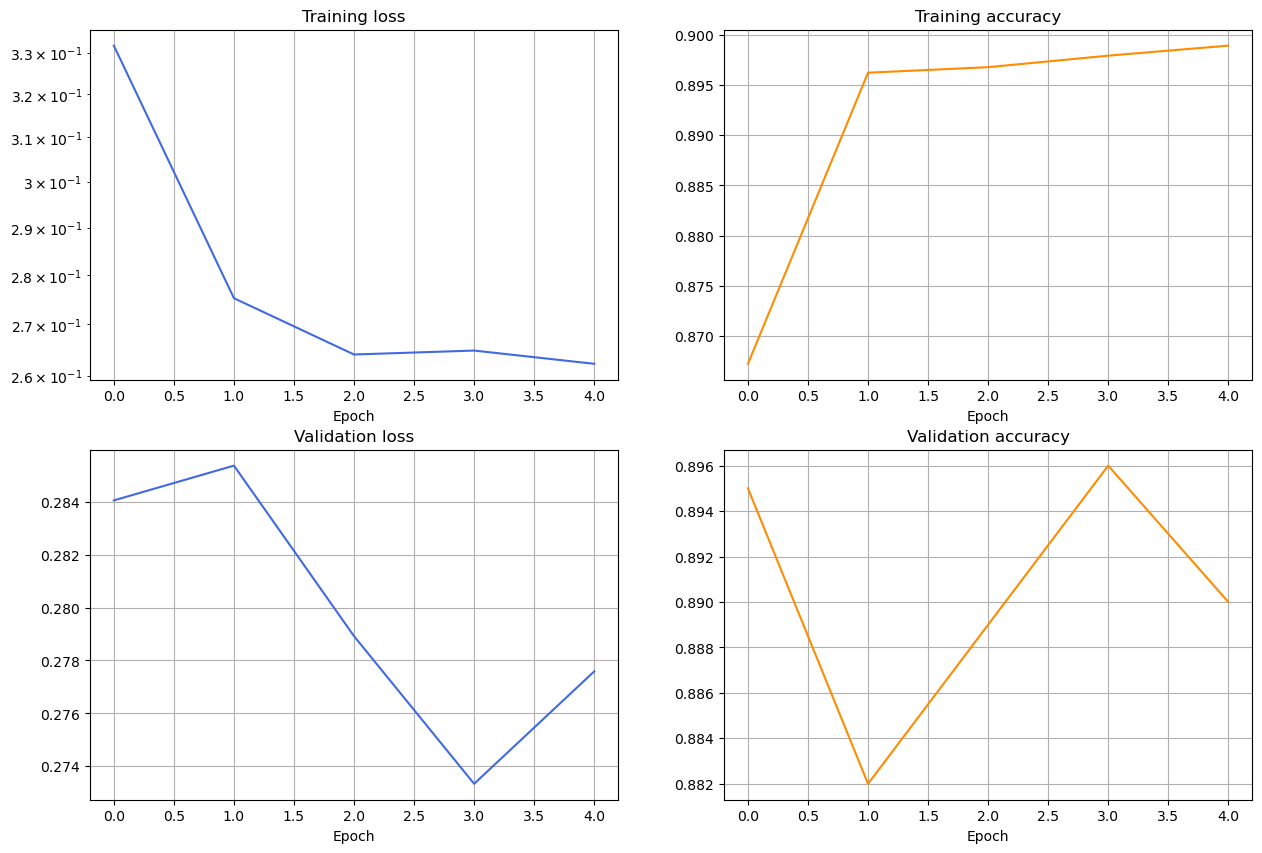

In [70]:
# plot training/validation loss and accuracy over training time
print(test(model_11, PSF_testing))
print(test(model_11, PSF_good_testing))
plot_model_results()